# Temperature Profile Classification
GMM classification of Southern Ocean Argo float temperature profile data. <br><br>
### Dask import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38880")
client

Client Scheduler: tcp://127.0.0.1:38880 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 9 Memory: 57.98 GB


<br>

### Choices for data

In [2]:
#File imports
maskName = "OceanMaskESM2"
dataFileName = "GMMSampleData2AL.npy"
sampleFileName = "GMMSampleTimeGeo2.npy"

#Data definitions
lastESMDecade = slice('2005-01','2014-12')

#Custom GMM variables
pcaNcontrol = 6
firstComponentMin = 2
firstComponentMax = 101
firstIterationSkip = 2
firstBicLoopControl = 1 #number of times bic value is calculated for each number of classes
secondIternation = True
secondBicLoopControl = 4
bicSpread = 5
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [4]:
sampleDataLabelled = np.load(dataFileName)
sampleDepthAxis = sampleDataLabelled[0]
sampleData = sampleDataLabelled[1:]

sampleTimeGeo = np.load(sampleFileName, allow_pickle=True)
print("Sample data loaded into sampleData.\nSample time geo data loaded into sampleTimeGeo.")

Sample data loaded into sampleData.
Sample time geo data loaded into sampleTimeGeo.


<br>
<b>Loading ocean Mask</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Combining sample data and sample time/geo data</b>

In [6]:
metaData = {"Lat":sampleTimeGeo[0], "Lon":sampleTimeGeo[1], "Time":sampleTimeGeo[2]}
sampleMetaDF = pd.DataFrame(metaData, columns=["Lat", "Lon", "Time"])
sampleDataDF = pd.DataFrame(sampleData, columns=sampleDepthAxis)
sampleDF = pd.concat([sampleMetaDF,sampleDataDF], axis=1)
print("SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.")

SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li>bicPlot - Plots BIC score array against component number.
<li>tempPointPlot - Plots the temperature profile of a single point against depth.
<li>tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [7]:
def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([np.min(bicArray)*1.01 - 0.02*bicArrayMax, bicArrayMax])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)
    
    
def tempPointPlot(dataArray, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis)
    plt.title(str(title))
    plt.gca().invert_yaxis()

    
def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0])[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)'''

print("Plotting functions defined")

Plotting functions defined


<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [8]:
pca = PCA(n_components=pcaNcontrol) #initialising PCA 
pca.fit(sampleData) #fitting model to data
sampleDataPCA = pca.transform(sampleData) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes.

The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Choices for data](#Choices-for-data).

In [9]:
bicMin = np.infty
bicComponentMin = firstComponentMin
bicRaw1 = np.empty(shape=(0,firstBicLoopControl))

for i in range(firstComponentMin, firstComponentMax, firstIterationSkip):
    bicCurrent = np.empty(shape=(0))
    
    for j in range(firstBicLoopControl):    #Number of iterations for each number of components
        GMModel = mixture.GaussianMixture(n_components = i, covariance_type = cvType) #Run modelling
        GMModel.fit(sampleDataPCA)
        
        bicCurrent = np.append(bicCurrent, GMModel.bic(sampleDataPCA))
        if bicCurrent[-1] < bicMin:   #if latest BIC score is lowest, update and save model
            bicMin = bicCurrent[-1]
            bicComponentMin = i
            bestGMModel = GMModel
        
    bicRaw1 = np.append(bicRaw1, [bicCurrent], axis=0)
    if i%5 == 0:
        print("Components "+str(i)+" complete.")

if secondBicLoopControl:
    secondComponentMin = bicComponentMin - bicSpread
    secondComponentMax = bicComponentMin + bicSpread
    bicRaw2 = np.empty(shape=(0, secondBicLoopControl))
    
    for i in range(secondComponentMin, secondComponentMax, 1):
        bicCurrent = np.empty(shape=(0))

        for j in range(secondBicLoopControl):    #Number of iterations for each number of components
            GMModel = mixture.GaussianMixture(n_components = i, covariance_type = cvType) #Run modelling
            GMModel.fit(sampleDataPCA)

            bicCurrent = np.append(bicCurrent, GMModel.bic(sampleDataPCA))
            
            if bicCurrent[-1] < bicMin:   #if latest BIC score is lowest, update and save model
                bicMin = bicCurrent[-1]
                bicComponentMin = i
                bestGMModel = GMModel

        bicRaw2 = np.append(bicRaw2, [bicCurrent], axis=0)
        print("Components "+str(i)+" complete.")
  
    
componentNo = bestGMModel.n_components

if componentNo != bicComponentMin:
    print("Warning, error with assigning optimum GMM")

print("Modelling and scoring complete. The lowest bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")
print("BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.")

Components 10 complete.
Components 20 complete.
Components 30 complete.
Components 40 complete.
Components 50 complete.
Components 60 complete.
Components 70 complete.
Components 80 complete.
Components 90 complete.
Components 45 complete.
Components 50 complete.
Modelling and scoring complete. The lowest bicScore was 285627.86 for 46.
BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.


In [22]:
bicRaw2

array([[287447.24532061, 286813.93237295, 287135.57055007,
        286947.72028336],
       [286656.72716623, 287357.92372786, 286161.91378575,
        286339.24054812],
       [287238.65716213, 286933.60636062, 287106.67957632,
        285891.70473705],
       [287626.34093459, 286820.86014056, 286705.00556231,
        286518.33631894],
       [287158.86264956, 287221.38499627, 286540.33667322,
        286352.90013966],
       [287397.44186993, 286296.94470172, 286474.74009096,
        286695.0766619 ],
       [286432.50706171, 286307.15962051, 286185.87134228,
        286028.76638132],
       [286473.77245355, 286936.77505413, 286285.10516383,
        286678.02713526],
       [286937.57345351, 286674.07760858, 286948.53597235,
        286935.73184387],
       [287052.64735019, 286510.85555087, 286686.70552994,
        286750.41647047]])

<br>

### BIC score calculations
The average and minimum BIC scores for each number of components are calculated and stored in the corresponding arrays.

In [10]:
bicAvg1 = np.empty(shape=(0))
bicAvg2 = np.empty(shape=(0))
bicMin1 = np.empty(shape=(0))
bicMin2 = np.empty(shape=(0))

for i in range(len(bicRaw1)):
    bicAvg1 = np.append(bicAvg1, np.mean(bicRaw1[i]))
    bicMin1 = np.append(bicMin1, np.min(bicRaw1[i]))
    
for i in range(len(bicRaw2)):
    bicAvg2 = np.append(bicAvg2, np.mean(bicRaw2[i]))
    bicMin2 = np.append(bicMin2, np.min(bicRaw2[i]))

print("BIC score sorting finished. Lowest scores for each component value stored in bicMin1/2, with average BIC scores stored in bicAvg1/2.")

BIC score sorting finished. Lowest scores for each component value stored in bicMin1/2, with average BIC scores stored in bicAvg1/2.


<br>

### BIC score plotting
Plotting the BIC scores from the modelling. The minimum BIC score indicates the ideal number of classes to be used in the model.

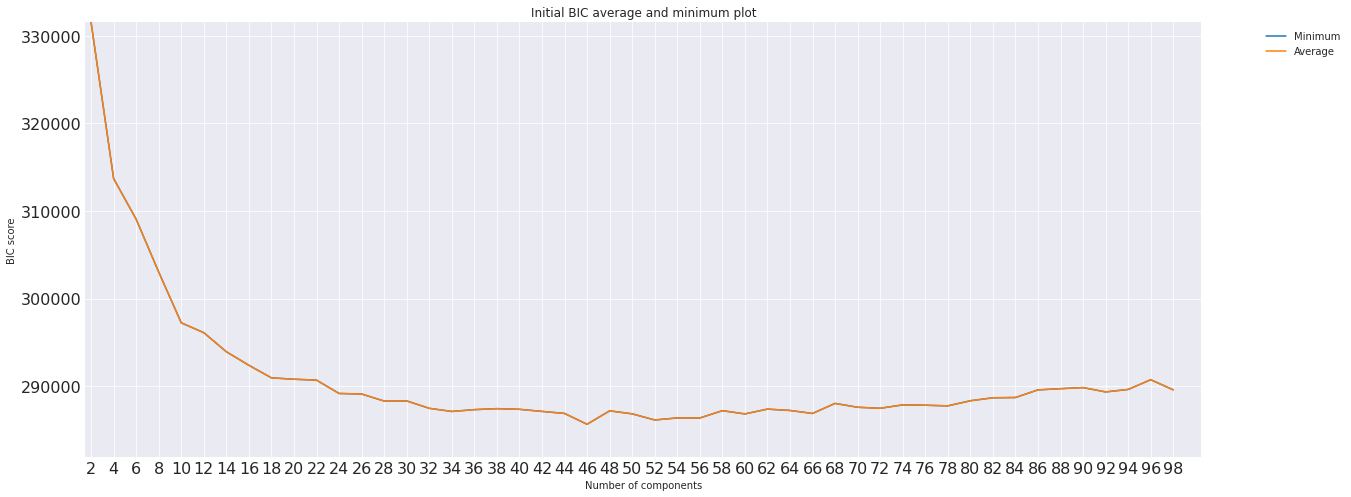

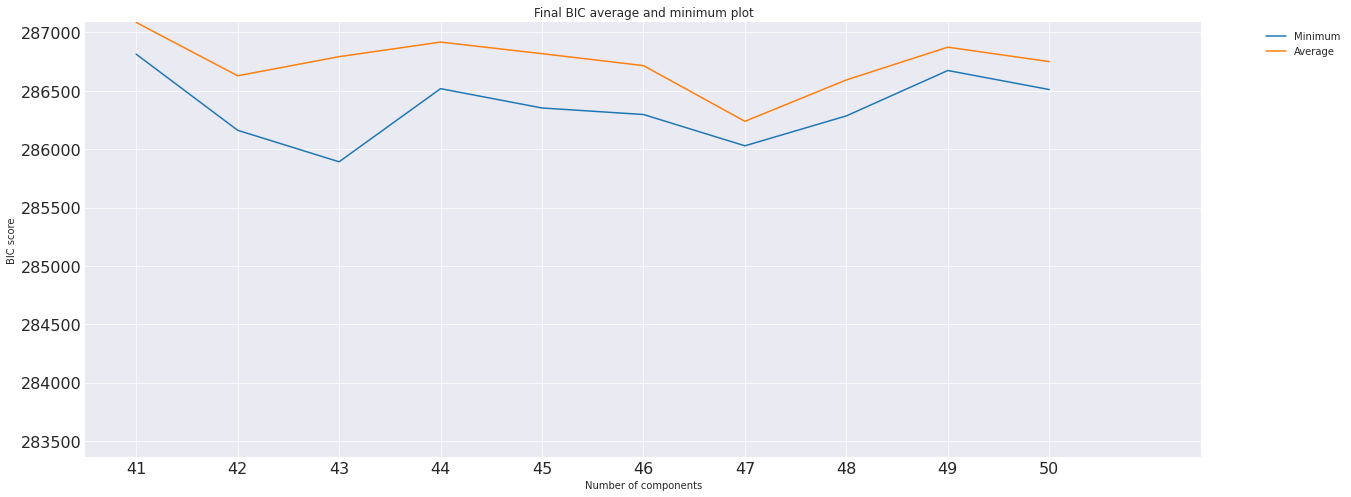

Component number with minimum BIC score: 46.


In [20]:
bicPlot(bicMin1, firstComponentMin, firstComponentMax, firstIterationSkip, "Initial BIC minimum plot", "Minimum", 1)
bicPlot(bicAvg1, firstComponentMin, firstComponentMax, firstIterationSkip, "Initial BIC average and minimum plot", "Average", 1)
bicPlot(bicMin2, secondComponentMin, secondComponentMax, 1,"Final BIC minimum plot", "Minimum", 2)
bicPlot(bicAvg2, secondComponentMin, secondComponentMax, 1, "Final BIC average and minimum plot", "Average", 2)

plt.show()
print("Component number with minimum BIC score: "+str(componentNo)+".")

<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [12]:
labels = bestGMModel.predict(sampleDataPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)

try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (46 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

In [13]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [14]:
surfaceMeans = sampleDFMeans[sampleDepthAxis[0]].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [15]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print(" Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
 Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [16]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     -1.775534
1     -1.762151
2     -1.753771
3     -1.675314
4     -0.563553
5      0.292640
6      0.421545
7      0.430506
8      0.680597
9      1.186959
10     2.124023
11     2.326687
12     2.437482
13     3.403609
14     4.941600
15     4.979802
16     5.314214
17     6.399107
18     6.647714
19     7.340354
20     8.526151
21     9.398881
22     9.865478
23    10.403013
24    11.455716
25    11.809374
26    12.068361
27    12.241848
28    12.686900
29    14.068786
30    14.566033
31    14.646453
32    15.304684
33    16.162696
34    16.498215
35    17.002570
36    17.668456
37    17.916331
38    18.567773
39    19.075100
40    19.246108
41    19.725708
42    20.422640
43    21.215541
44    21.236935
45    21.270020
Name: 5.0, dtype: float64


<br>

### Plotting the means and standard deviations of the classes by profile

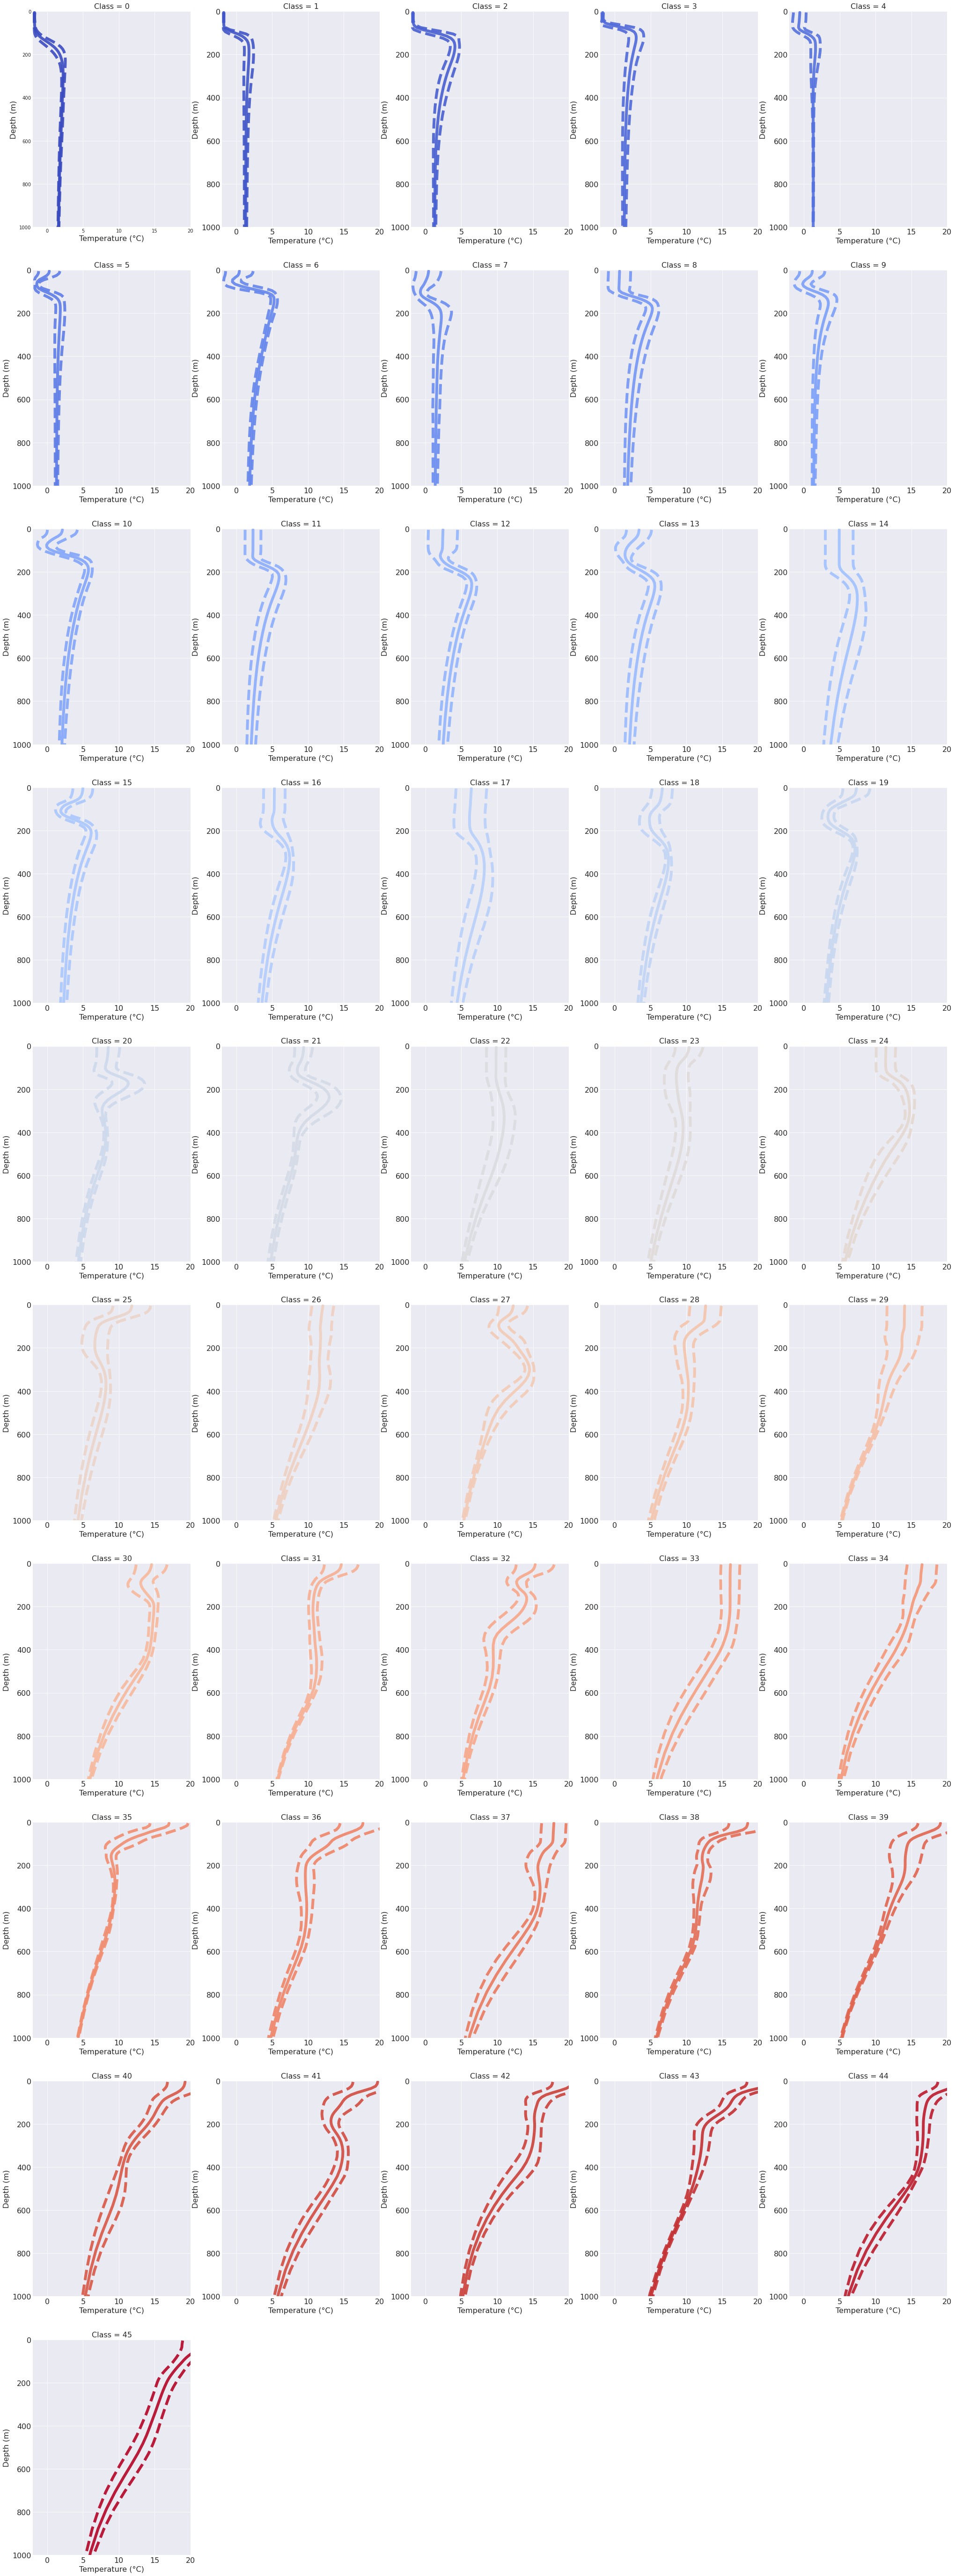

In [17]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

# TODO
Notes: data standardisation removed (pca used dataScaled)

Ideas: combine sampleData and sampleTimeGeo into df that can have labels appended in assignement
<br>
<br>

### Plotting location and cluster

In [18]:
def invert(inArray):
    outArray = []
    for i in range(len(inArray)):
        for j in range(len(inArray)):
            if inArray[j] == i:
                outArray.append(j)
    return outArray

floatLon = df["x"]
floatLat = df["y"]
floatCol = df["label"]
floatColLookup = invert(dfgMeans["label"])
floatColSwitched = []

for i in floatCol:
    floatColSwitched.append(floatColLookup[i])

NameError: name 'df' is not defined

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.coastlines()
ax.gridlines()
plt.scatter(floatLon, floatLat, color=palette[floatColSwitched], transform=ccrs.PlateCarree(),cmap='RdBu_r')
plt.title("GMM groups, sorted by mean temperature")